# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.061739,False,-1.743644
1,0.010838,True,6.562817
2,1.205978,True,3.720317
3,-0.355414,False,0.177533
4,-0.182426,False,0.707859
...,...,...,...
995,-2.204175,False,-3.714323
996,0.730946,True,6.478845
997,0.576172,True,5.554162
998,0.921638,True,5.661661


<Axes: xlabel='v0'>

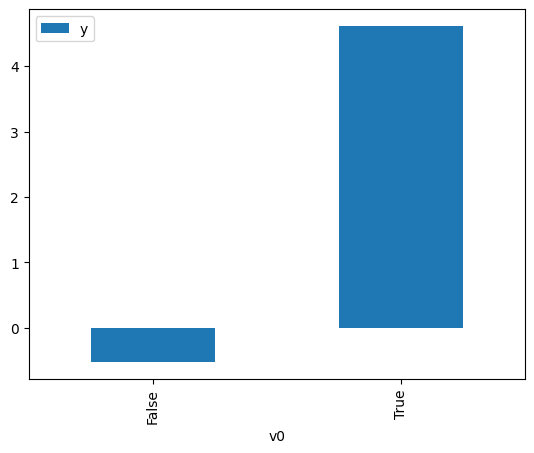

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

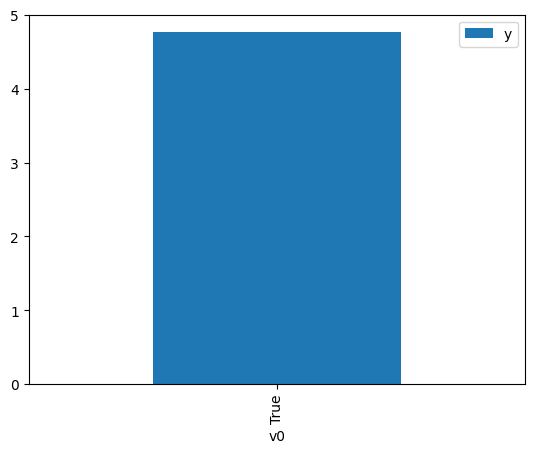

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.150210,False,1.023736,0.479560,2.085247
1,0.616937,False,-0.410546,0.266096,3.758039
2,-1.439795,False,-3.058390,0.956714,1.045245
3,-1.098332,False,-1.359056,0.917835,1.089520
4,-0.034717,False,1.482191,0.571446,1.749948
...,...,...,...,...,...
995,-1.506442,False,-2.688119,0.961906,1.039602
996,-1.517018,False,-0.363953,0.962673,1.038774
997,-0.588972,False,-0.639715,0.801450,1.247739
998,-0.972063,False,-2.144209,0.896688,1.115215


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.840397,True,6.847089,0.811698,1.231985
1,-1.258336,True,3.662999,0.061051,16.379645
2,-1.651482,True,4.710353,0.028784,34.740941
3,-0.989669,True,4.185273,0.100098,9.990225
4,0.557098,True,5.135549,0.709908,1.408633
...,...,...,...,...,...
995,-0.393488,True,3.946107,0.268014,3.731154
996,-1.586945,True,2.722990,0.032618,30.658265
997,-1.651482,True,4.710353,0.028784,34.740941
998,-0.456297,True,2.951388,0.244116,4.096408


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6726.
Date:                Wed, 29 May 2024   Prob (F-statistic):                        0.00
Time:                        16:30:34   Log-Likelihood:                         -1428.7
No. Observations:                1000   AIC:                                      2861.
Df Residuals:                     998   BIC:                                      2871.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4698      0.032     45.381      0.000       1.406       1.533
x2             4.9500      0.054     91.172      0.000       4.843       5.057
==============================================================================
Omnibus:                        3.563   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                3.633
Skew:                          -0.136   Prob(JB):                        0.163
Kurtosis:                       2.886   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""